![Prudential](http://static.wixstatic.com/media/282a5d_e3e7a437f4b04f82951ea49f379f567e.png)

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\asus1\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Objective

In this dataset, you are provided over a hundred variables describing attributes of life insurance applicants. The task is to predict the "Response" variable for each Id in the test set. "Response" is an ordinal measure of risk that has 8 levels.

#### File descriptions

* __train.csv.gz__ - the training set, contains the Response values
* __test.csv.gz__ - the test set, you must predict the Response variable for all rows in this file
* __sample_submission.csv.gz__ - a sample submission file in the correct format
Data fields

Variable|Description
---|---
Id|A unique identifier associated with an application.
Product_Info_1-7|A set of normalized variables relating to the product applied for
Ins_Age|Normalized age of applicant
Ht|Normalized height of applicant
Wt|Normalized weight of applicant
BMI|Normalized BMI of applicant
Employment_Info_1-6|A set of normalized variables relating to the employment history of the applicant.
InsuredInfo_1-6|A set of normalized variables providing information about the applicant.
Insurance_History_1-9|A set of normalized variables relating to the insurance history of the applicant.
Family_Hist_1-5|A set of normalized variables relating to the family history of the applicant.
Medical_History_1-41|A set of normalized variables relating to the medical history of the applicant.
Medical_Keyword_1-48|A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.
Response|This is the target variable, an ordinal variable relating to the final decision associated with an application

#### The following variables are all categorical (nominal):

*  Employment\_Info\_[2-3, 5]
*  Family_Hist_1, 
*  Insurance\_History\_[1-4, 7-9]
*  InsuredInfo\_[1-7], 
*  Medical\_History\_[2-9, 11-14, 16-23, 25-31, 33-41]
*  Product\_Info\_[1-3, 5-7] 

#### The following variables are continuous:

* BMI 
* Employment\_Info\_[1, 4, 6] 
* Family\_Hist\_[2-5]
* Ht 
* Ins\_Age 
* Insurance\_History\_5 
* Product\_Info\_4 
* Wt 

#### The following variables are discrete:

* Medical\_History\_[1, 10, 15, 24, 32]

Medical_Keyword_1-48 are dummy variables.

In [3]:
train = pd.read_csv('input/train.csv.gz')
pred_col = 'Response'

In [115]:
nul_cols = [col for col in train.columns[train.isnull().any()]]
cat_cols = [col for col in train.columns[train.dtypes=='object'] if col not in nul_cols]

dummies = pd.get_dummies(train[cat_cols])
x_train = train.drop(['Id', pred_col] + cat_cols + nul_cols, axis=1)
x_train = x_train.join(dummies)
y_train = train[pred_col]

In [5]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

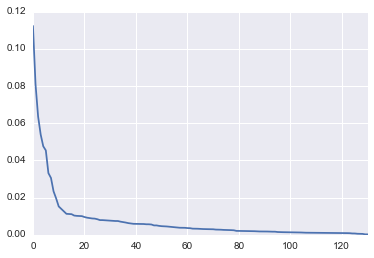

In [6]:
important_features = (pd.DataFrame({
        'feature': x_train.columns,
        'weights': rf.feature_importances_})
    .sort_values('weights', ascending=False)
    .reset_index(drop=True))
important_features['weights'].plot()

In [7]:
top_features = important_features.ix[:10, 'feature']

## Evaluation

Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two ratings. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement between the raters than expected by chance, this metric may go below 0.

The response variable has 8 possible ratings.  Each application is characterized by a tuple ($e_a$,$e_b$), which corresponds to its scores by Rater A (actual risk) and Rater B (predicted risk).  The quadratic weighted kappa is calculated as follows.

First, an N x N histogram **matrix O** is constructed, such that $O_{i,j}$ corresponds to the number of applications that received a rating i by A and a rating j by B. 

An N-by-N **matrix of weights, w**, is calculated based on the difference between raters' scores:

$$w_{i,j}=\frac{(i-j)^2}{(N-1)^2}$$

An N-by-N histogram **matrix of expected ratings, E**, is calculated, assuming that there is no correlation between rating scores.  This is calculated as the outer product between each rater's histogram vector of ratings, normalized such that E and O have the same sum.

From these three matrices, the quadratic weighted kappa is calculated as: 

$$\kappa = 1 - \frac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}$$

In [8]:
def quadratic_weighted_kappa(y_true, y_pred):
    n_ratings = 8
    
    # Matrix O
    matrix_O = np.histogram2d(y_true, y_pred, bins=[n_ratings, n_ratings])[0].astype(np.float64)
    
    # Matrix W
    ratings = np.arange(n_ratings) + 1
    xx, yy = np.meshgrid(ratings, ratings)
    z = np.c_[xx.ravel(), yy.ravel()]
    def weight_fn(arr, N=n_ratings):
        i, j = arr
        return (i - j)**2 / float((N - 1)**2)
    matrix_W = np.apply_along_axis(func1d=weight_fn, axis=1, arr=z).reshape((n_ratings, n_ratings))

    # Matrix E
    hist_true = np.bincount(y_true, minlength=n_ratings+1)[1:]
    hist_pred = np.bincount(y_pred, minlength=n_ratings+1)[1:]
    matrix_E = np.outer(hist_true, hist_pred).astype(np.float64)
    matrix_E = matrix_E * (matrix_O.sum() / matrix_E.sum())
    
    numer = np.sum(matrix_W * matrix_O)
    denom = np.sum(matrix_W * matrix_E)
    return 1 - numer/denom
quadratic_weighted_kappa = make_scorer(quadratic_weighted_kappa)
# quadratic_weighted_kappa(y_true, y_pred)

In [196]:
print 'Using all features...'
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring=quadratic_weighted_kappa)
scores.mean()

0.46888088213095125

Score using top features...

In [123]:
class CustomLM(LinearRegression):
    def predict(self, *args):
        pred = super(CustomLM, self).predict(*args)
        return np.clip(np.round(pred), 1, 8).astype(np.int16)
lm = CustomLM()
scores = cross_val_score(lm, x_train, y_train, cv=10, scoring=quadratic_weighted_kappa)
scores.mean()

0.515062374588384

In [9]:
from sklearn.linear_model import RandomizedLasso
rlasso = RandomizedLasso()
rlasso.fit(x_train, y_train)

RandomizedLasso(alpha='aic', eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [10]:
feat_weight = (pd.DataFrame({
            'weight': rlasso.all_scores_.ravel(), 
            'feature': x_train.columns.tolist()}))
feat_weight = feat_weight.sort_values('weight', ascending=False)
imp_feats = feat_weight.ix[feat_weight['weight']==1, 'feature']

In [533]:
cross_val_score(rf, x_train[imp_feats], y_train, cv=10, scoring=quadratic_weighted_kappa).mean()

0.46741101642136906

In [124]:
cross_val_score(lm, x_train[imp_feats], y_train, cv=10, scoring=quadratic_weighted_kappa).mean()

0.51398347404519229